In [1]:
from loader.mnist import MNIST, MNIST_NORMALIZATION
from loader.emnist import EMNIST
from loader.fmnist import FashionMNIST
from core.mln.mixture_head import mln_cnn
from core.mln.func import mace_loss,mln_gather,mln_uncertainties
from torchvision import datasets,transforms
import torch
import numpy as np
from core.score import plot, histogram_binning_calibrator, plot_confidence_hist
import matplotlib.pyplot as plt

## OOD as EMNIST or FMNIST

In [2]:
tf = transforms.Compose([
            transforms.ToTensor(),
            MNIST_NORMALIZATION,
        ])
train_data = MNIST('./dataset/',download=True,transform=tf)
test_id = MNIST('./dataset/', download=True,transform=tf,train=False)
val_id = MNIST('./dataset/', download=True,transform=tf,train=True,val=True)
test_near_ood = EMNIST('./dataset/',download=True,transform=tf,train=False,split='letters')
test_far_ood = FashionMNIST('./dataset/',download=True,transform=tf,train=False)

train_loader = torch.utils.data.DataLoader(train_data,batch_size = 128,shuffle=True)
val_id_loader = torch.utils.data.DataLoader(val_id,batch_size = 128,shuffle=False)
test_id_loader = torch.utils.data.DataLoader(test_id,batch_size = 128,shuffle=False)
test_near_ood_loader = torch.utils.data.DataLoader(test_near_ood,batch_size = 128,shuffle=False)
test_far_ood_loader = torch.utils.data.DataLoader(test_far_ood,batch_size = 128,shuffle=False)

In [3]:
model = mln_cnn(y_dim=10,sig_min=1,sig_max=2,
                mu_min=-3,mu_max=3,k=10).to('cuda:0')
optimizer = torch.optim.Adam(model.parameters(),lr=1e-4, 
                weight_decay=1e-4)


### Training

In [4]:
from torch.nn.modules.loss import _Loss
model.train()
for e in range(5):
    for image,label in train_loader:
        out = model(image.to('cuda'))
        label = torch.eye(10)[label]
        loss_out = mace_loss(out['pi'],out['mu'],out['sigma'],label.to('cuda'))
        loss = loss_out['mace_avg'] - 1e-4* loss_out['epis_avg'] + 1*loss_out['alea_avg']
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    print(loss)
    print(loss_out['mace_avg'].item(), 
            loss_out['epis_avg'].item(), loss_out['alea_avg'].item())

tensor(1.1787, device='cuda:0', grad_fn=<AddBackward0>)
0.17335960268974304 0.010737484320998192 1.0053589344024658
tensor(1.1040, device='cuda:0', grad_fn=<AddBackward0>)
0.10297437012195587 0.00472992891445756 1.0010448694229126
tensor(1.0515, device='cuda:0', grad_fn=<AddBackward0>)
0.050421342253685 0.004366458859294653 1.0010993480682373
tensor(1.0166, device='cuda:0', grad_fn=<AddBackward0>)
0.01609896868467331 0.003906058147549629 1.00050687789917
tensor(1.0456, device='cuda:0', grad_fn=<AddBackward0>)
0.04525550454854965 0.002245604991912842 1.0003143548965454


### Test Accuracy

In [5]:
model.eval()
y_true = []
with torch.no_grad():
    num_acc = 0
    total = 0
    for image, label in test_id_loader:
        out = model(image.to('cuda'))
        out = mln_gather(out['pi'],out['mu'],out['sigma'])
        _,pred_logit = torch.max(out['mu_sel'],dim=-1)
        y_true += (label==pred_logit.cpu()).numpy().tolist()
        num_acc += (label == pred_logit.cpu()).sum().item()
        total += label.shape[0]
print("Accuracy:{}".format(num_acc/total))

Accuracy:0.9871


### Uncertainty

In [6]:
in_alea = np.zeros((0))
in_epis = np.zeros((0))
with torch.no_grad():
    for image,label in test_id_loader:
        out = model(image.to('cuda'))
        unct = mln_uncertainties(out['pi'],out['mu'],out['sigma'])
        in_epis = np.concatenate((in_epis,unct['epis'].cpu().numpy()))
        in_alea = np.concatenate((in_alea,unct['alea'].cpu().numpy()))
print(np.mean(in_epis),np.mean(in_alea))

out_near_alea = np.zeros((0))
out_near_epis = np.zeros((0))
with torch.no_grad():
    for image,label in test_near_ood_loader:
        out = model(image.to('cuda'))
        unct = mln_uncertainties(out['pi'],out['mu'],out['sigma'])
        out_near_epis = np.concatenate((out_near_epis,unct['epis'].cpu().numpy()))
        out_near_alea = np.concatenate((out_near_alea,unct['alea'].cpu().numpy()))

print(np.mean(out_near_epis),np.mean(out_near_alea))


out_far_alea = np.zeros((0))
out_far_epis = np.zeros((0))
with torch.no_grad():
    for image,label in test_far_ood_loader:
        out = model(image.to('cuda'))
        unct = mln_uncertainties(out['pi'],out['mu'],out['sigma'])
        out_far_epis = np.concatenate((out_far_epis,unct['epis'].cpu().numpy()))
        out_far_alea = np.concatenate((out_far_alea,unct['alea'].cpu().numpy()))
print(np.mean(out_far_epis),np.mean(out_far_alea))


0.001574849480128887 1.0001707238197326
0.006537145318173276 1.0011177380956136
0.008017543747598074 1.0035816109538078


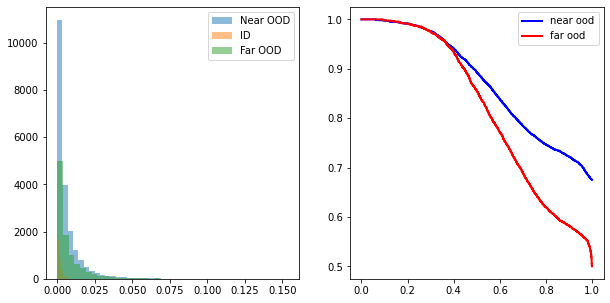

Near AUROC:0.7413943990384616, Far AUROC: 0.7836425199999999


In [7]:
auroc = plot(in_epis,out_near_epis, out_far_epis,name='Epis',reverse=False)
print("Near AUROC:{}, Far AUROC: {}".format(auroc[0],auroc[1]))

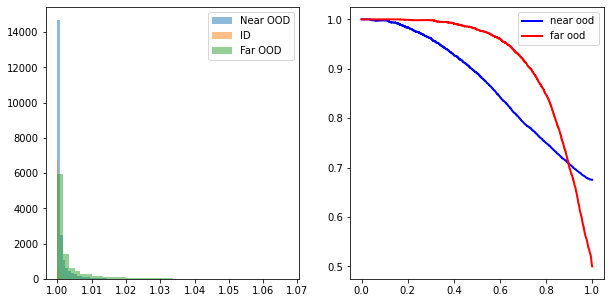

Near AUROC:0.7349118461538462, Far AUROC: 0.8961892


In [8]:
auroc = plot(in_alea,out_near_alea, out_far_alea,name='Alea',reverse=False)
print("Near AUROC:{}, Far AUROC: {}".format(auroc[0],auroc[1]))

## Calibration

In [9]:
model.eval()
val_in_alea = np.zeros((0))
val_in_epis = np.zeros((0))
val_y_true = []
with torch.no_grad():
    for image,label in val_id_loader:
        out = model(image.to('cuda'))
        unct = mln_uncertainties(out['pi'],out['mu'],out['sigma'])
        val_in_epis = np.concatenate((val_in_epis,unct['epis'].cpu().numpy()))
        val_in_alea = np.concatenate((val_in_alea,unct['alea'].cpu().numpy()))
        out = mln_gather(out['pi'],out['mu'],out['sigma'])
        _,pred_logit = torch.max(out['mu_sel'],dim=-1)
        val_y_true += (label==pred_logit.cpu()).numpy().tolist()


In [10]:

def plot_confidence_hist(prob_true,prob_pred,NAME):
    plt.figure()
    plt.title(NAME)
    for e,(t,p) in enumerate(zip(prob_true,prob_pred)):
        if e == len(prob_true)-1:
            width = 1-p
        else:
            width = prob_pred[e+1] - p
        plt.bar(p,t,width,align = 'edge',color=[0,0,1,0.2])
    plt.plot([0,1],[0,1])
    plt.show()
    

ECE(%):  1.0308552945239617


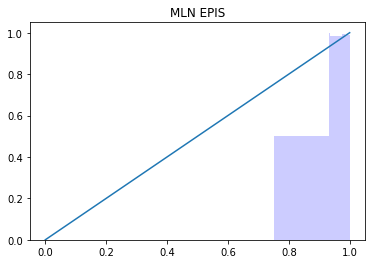

In [11]:
cval_score = val_in_epis*-1
cid_score = in_epis* -1
min_en= cval_score.min() - 1e-3
max_en = cval_score.max() + 1e-3

cal = histogram_binning_calibrator(100,min_en, max_en)
cal.fit(cval_score,val_y_true)
prob_pred, prob_true, ece = cal.inference(cid_score, y_true)

plot_confidence_hist(prob_true,prob_pred,'MLN EPIS')

ECE(%):  0.7639163531359552


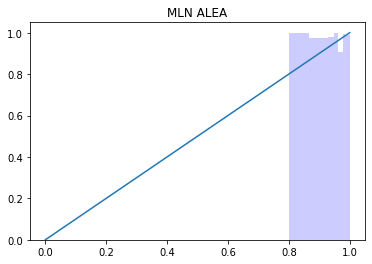

In [12]:
cval_score = val_in_alea*-1
cid_score = in_alea* -1
min_en= cval_score.min() - 1e-3
max_en = cval_score.max() + 1e-3

cal = histogram_binning_calibrator(100,min_en, max_en)
cal.fit(cval_score,val_y_true)
prob_pred, prob_true, ece = cal.inference(cid_score, y_true)

plot_confidence_hist(prob_true,prob_pred,'MLN ALEA')